In [4]:
!pip install tensorflow==2.13.0
!pip install tensorflow_hub==0.14.0
!pip install tensorflow_text==2.13.0

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("CUDA Available: ", tf.test.is_built_with_cuda())
print("GPU Device: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
CUDA Available:  True
GPU Device:  []


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset_path = "/content/drive/MyDrive/Datasets/Spam_ham_dataset_kaggle/spam_ham_dataset.csv"

In [10]:
import pandas as pd

df = pd.read_csv(dataset_path)
print(df.head(5))

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


In [11]:
df.groupby('label').describe()

Unnamed: 0                                                         \
           count    mean          std     min      25%     50%      75%   
label                                                                     
ham       3672.0  1835.5  1060.159422     0.0   917.75  1835.5  2753.25   
spam      1499.0  4421.0   432.868340  3672.0  4046.50  4421.0  4795.50   

              label_num                                     
          max     count mean  std  min  25%  50%  75%  max  
label                                                       
ham    3671.0    3672.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
spam   5170.0    1499.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [12]:
df['label'].value_counts()

,count
label,
ham,3672
spam,1499


In [13]:
df_spam = df[df['label']=='spam']
df_spam.shape

(1499, 4)

In [14]:
df_ham = df[df['label']=='ham']
df_ham.shape

(3672, 4)

In [15]:
# Since we have an imbalanced dataset, we will try to balance it using dowsampling

df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(1499, 4)

In [16]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(2998, 4)

In [17]:
df_balanced.sample(5)

,Unnamed: 0,label,text,label_num
1907,4133,spam,Subject: \r\nthe only solution to penis growth...,1
2458,492,ham,Subject: vacation scheduled\r\ni will be on va...,0
2578,3565,ham,"Subject: need deal for march 2000\r\ndaren ,\r...",0
1864,4207,spam,Subject: \r\nthe only fix to penis growth\r\nl...,1
4753,3073,ham,Subject: re : nom / actual volume for april 16...,0


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df_balanced['text'], df_balanced['label_num'], stratify=df_balanced['label_num'])

In [19]:
X_train.head(5)

,text
1742,Subject: brandywine\r\nthere was flow at hpl m...
597,Subject: absentminded volition cavil corpus de...
3941,"Subject: hpl noms . for jan . 23 , 2001\r\n( s..."
587,Subject: revised\r\n- - - - - - - - - - - - - ...
2923,Subject: one of the best on the net !\r\nhave ...


In [20]:
Y_train.head(5)

,label_num
1742,0
597,1
3941,0
587,0
2923,1


In [21]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-10-h-768-a-12/2")

In [22]:
# An example on how the vector embeddings are generated by the BERT encoder

def get_sentence_embeddings(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']


get_sentence_embeddings(["This is an exclusive discount. Win $1000"])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.4448401 ,  0.21833791,  0.06822799, -0.7910796 ,  0.90148395,
         0.23045921,  0.99759984,  0.90477455,  0.00332294, -0.08885989,
        -0.24013363, -0.11060346, -0.516859  ,  0.57757884,  0.41076094,
         0.9827326 ,  0.97243005,  0.3019434 ,  0.46701667,  0.5484784 ,
         0.42198128,  0.8363521 ,  0.2445524 , -0.543365  ,  0.06833939,
        -0.9402594 ,  0.50741494, -0.5802214 ,  0.41820705,  0.64604   ,
         0.3798581 ,  0.31305364,  0.5305882 ,  0.04308753,  0.10778435,
         0.9093475 ,  0.09898925,  0.40824336, -0.20222488, -0.42687756,
         0.3856694 ,  0.8682037 , -0.18775137,  0.8108307 , -0.57100034,
         0.5766256 , -0.00778366, -0.4320109 , -0.76622283,  0.47746006,
         0.91279954, -0.54119104,  0.37562257, -0.604825  ,  0.46115425,
        -0.32763496, -0.45529503, -0.8184017 ,  0.9935561 , -0.80737466,
        -0.37946713, -0.01709255,  0.14616683,  0.596073  ,  0.45667017,
 

In [23]:
#Another example which is a clear understandig on how we will be understandig vector
# in the context of a similarity search

example = get_sentence_embeddings([
    "monkey",
    "Vinay",
    "cow",
    "Charles",
    "grapes",
    "train",
    "orange",
    "Mahatma Gandhi"
])

In [24]:
# Now we can check the cosine similarity in this case

from sklearn.metrics.pairwise import cosine_similarity

# Checking the similarity for Vinay and Mahatma Gandhi where both are humans
# and more similar, hence the cosine similarity is high
cosine_similarity([example[1]], [example[7]])

array([[0.8283509]], dtype=float32)

In [25]:
# Checking the similarity for Vinay and Cow where both are differnt and less
# similar, hence the cosine similarity is poor
cosine_similarity([example[1]], [example[2]])

array([[0.26968092]], dtype=float32)

In [26]:
# Create Model to fine tune the BERT encoder
def create_bert_model():
    # Text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')

    # Preprocessing layer
    encoder_inputs = bert_preprocess(text_input)

    # Encoder layer
    outputs = bert_encoder(encoder_inputs)

    # Neural network layers
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

    # Create model
    return tf.keras.Model(text_input, net)


In [27]:
# Create and compile model
model = create_bert_model()

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text_input[0][0]']          
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

So in the above model summary, we can see that we have a total parameter of 95307266 in which only 769 para is trainable

In [29]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [30]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [31]:
with tf.device('/GPU:0'):
  history = model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
71/71 [==============================] - 87s 1s/step - loss: 0.5784 - accuracy: 0.6980 - precision: 0.6933 - recall: 0.7100
Epoch 2/10
71/71 [==============================] - 82s 1s/step - loss: 0.4063 - accuracy: 0.8603 - precision: 0.8689 - recall: 0.8488
Epoch 3/10
71/71 [==============================] - 81s 1s/step - loss: 0.3423 - accuracy: 0.8803 - precision: 0.8890 - recall: 0.8692
Epoch 4/10
71/71 [==============================] - 81s 1s/step - loss: 0.3022 - accuracy: 0.8946 - precision: 0.8963 - recall: 0.8923
Epoch 5/10
71/71 [==============================] - 81s 1s/step - loss: 0.2799 - accuracy: 0.8972 - precision: 0.9041 - recall: 0.8888
Epoch 6/10
71/71 [==============================] - 81s 1s/step - loss: 0.2597 - accuracy: 0.9075 - precision: 0.9082 - recall: 0.9066
Epoch 7/10
71/71 [==============================] - 81s 1s/step - loss: 0.2516 - accuracy: 0.9115 - precision: 0.9104 - recall: 0.9128
Epoch 8/10
71/71 [==============================] - 80s

Evaluating the Test Dataset

In [32]:
model.evaluate(X_test, Y_test)

24/24 [==============================] - 28s 1s/step - loss: 0.1896 - accuracy: 0.9413 - precision: 0.9559 - recall: 0.9253


[0.1895846426486969,
 0.9413333535194397,
 0.9559228420257568,
 0.9253333210945129]

In [33]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred.flatten() # Converting the predicted output from 2D to 1D

24/24 [==============================] - 28s 1s/step


In [34]:
import numpy as np

Y_pred = np.where(Y_pred > 0.5, 1, 0)
Y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(Y_test, Y_pred)
cm

array([[359,  16],
       [ 28, 347]])

Text(50.722222222222214, 0.5, 'Ground_Truth')

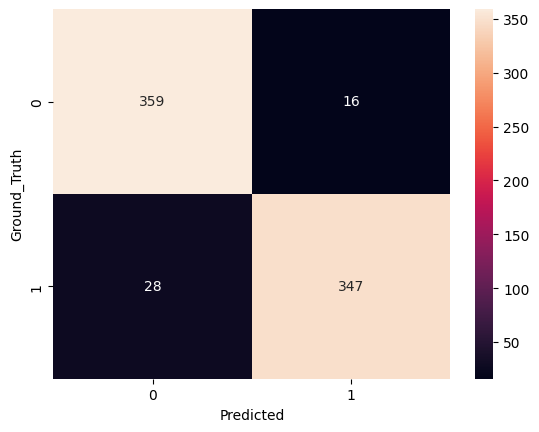

In [36]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Ground_Truth')


In [37]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       375
           1       0.96      0.93      0.94       375

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750



# Inference

In [41]:
review = [
    'Subject: Win a lottery of $5000, This is a one time offer',
    'Subject: Expense report for January'
]

model.predict(review)

1/1 [==============================] - 0s 214ms/step


array([[0.882],
       [0.318]], dtype=float16)